In [8]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

We do 3 approximation tests using "test_hmmbatchsgd.py" and "test_hmmbatchscd.py".

## SGD

Hamming Distance =  0.0


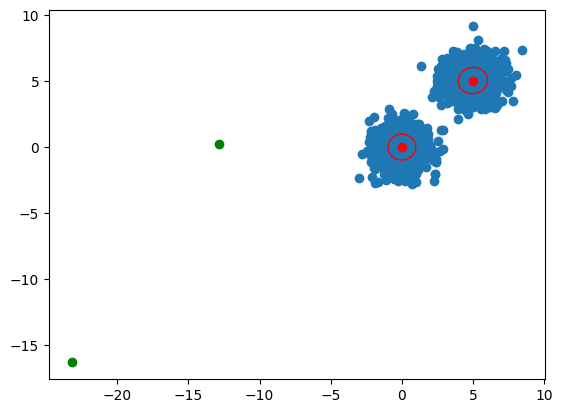

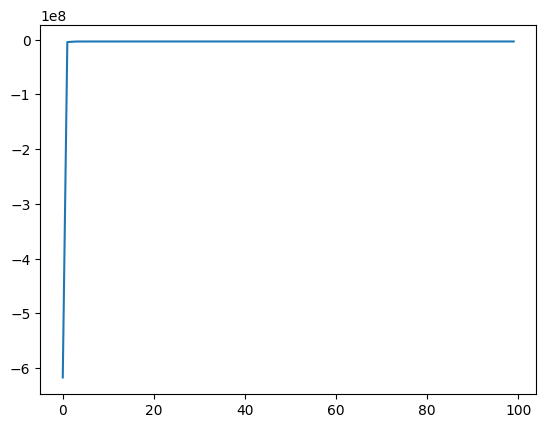

Hamming Distance =  0.0


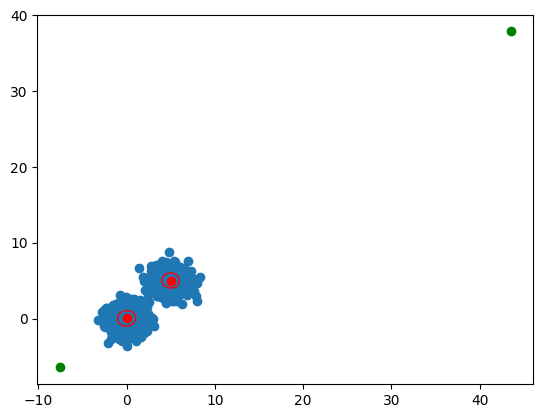

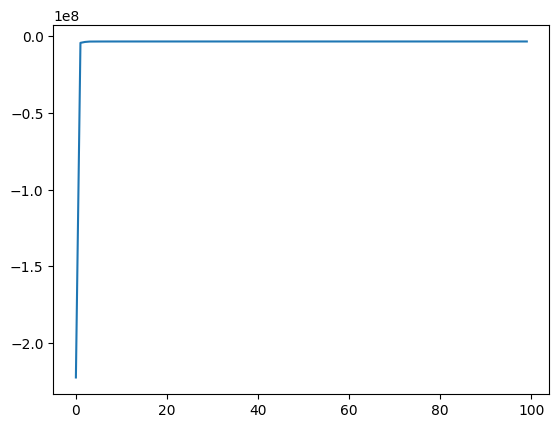

Hamming Distance =  0.0


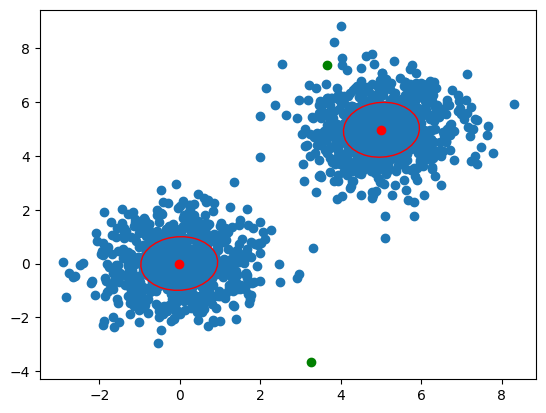

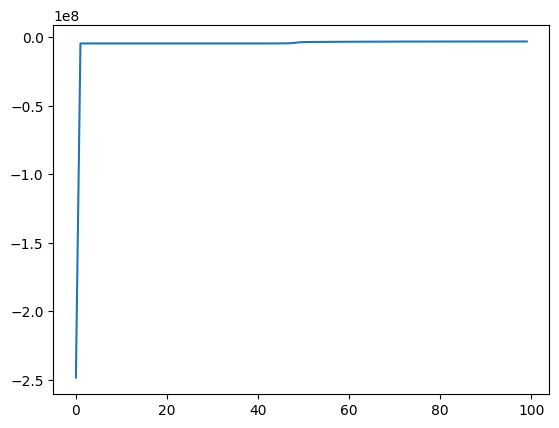

In [19]:
for i in range(3):
    test_hmmbatchsgd()

## CD

terminated early - convergence
Hamming Distance =  0.0


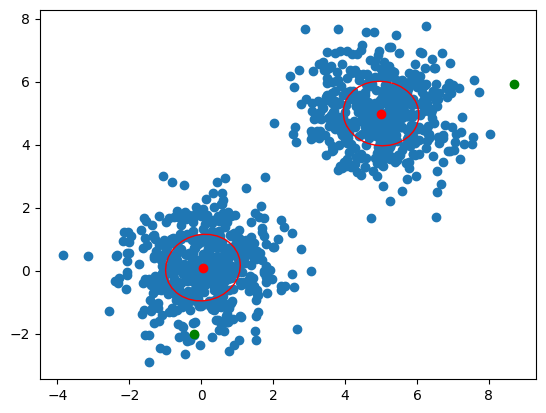

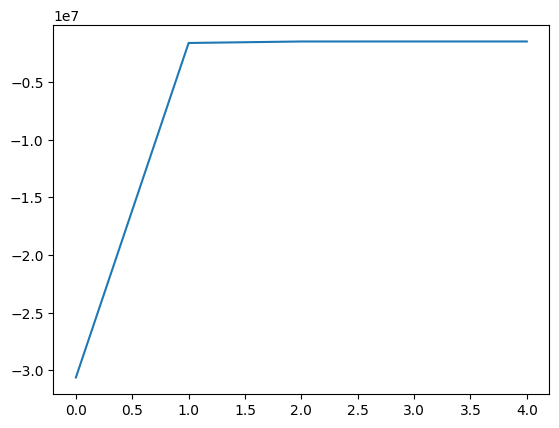

terminated early - convergence
Hamming Distance =  0.0


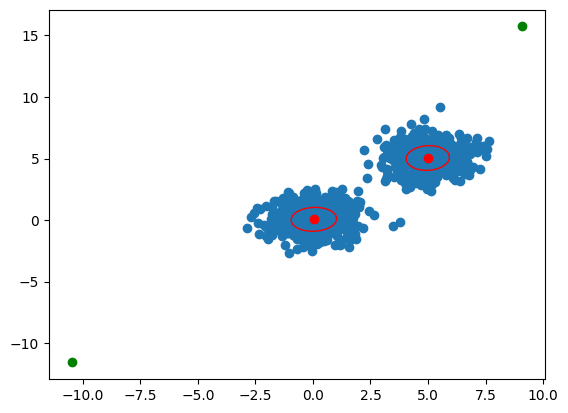

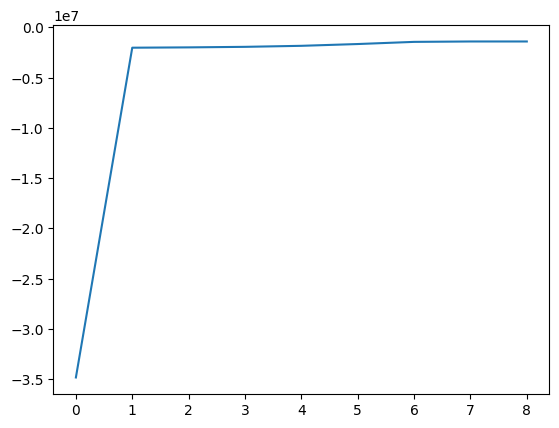

terminated early - convergence
Hamming Distance =  0.0


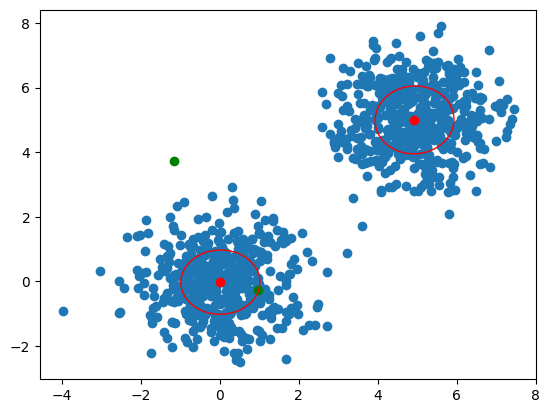

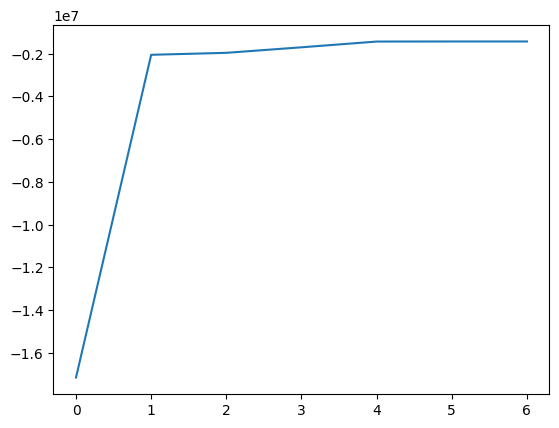

In [9]:
for i in range(3):
    test_hmmbatchcd()

### Interactive testing with comparision

ToDO  - finish this section

Hamming Distance =  0.0


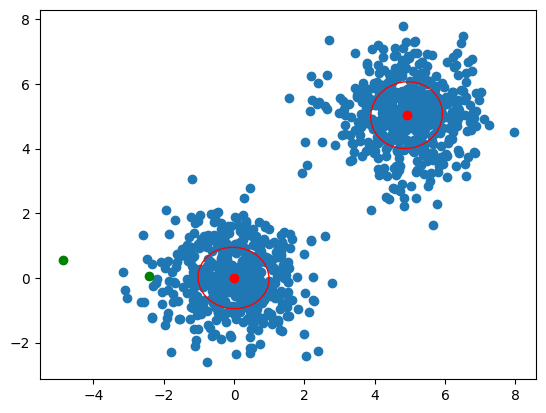

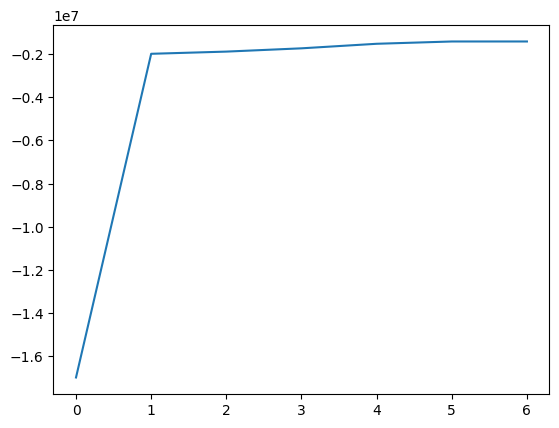

In [3]:
# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


# generating toy data using emissions (in 2 dimensions)

K = 2           # number of states  
D = K           #have to be equal (symmetry)
kappa_0 = 1     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

# define priors on emission to be multivariate gaussian with 0 mean and unit var (no covariance)

jump = 5
emit1 = Gaussian(mu=np.array([0,0]),
                    sigma=np.eye(2),
                    mu_0=np.zeros(2),
                    sigma_0=np.eye(2),
                    kappa_0=kappa_0,
                    nu_0=nu_0)
emit2 = Gaussian(mu=np.array([0,0])+jump,    # distance of blobs
                    sigma=np.eye(2),    # variance of blobs
                    mu_0=np.zeros(2),   # prior
                    sigma_0=np.eye(2),  # prior
                    kappa_0=kappa_0,    # prior
                    nu_0=nu_0)          # prior
emit = np.array([emit1, emit2])

# generate observations
N = 1000
obs = np.array([emit[int(np.round(i/N))].rvs()[0]
                for i in range(N)])

# set priors on emissions to be 0 mean  
# 0.75 frac of empirical covariance matrix

mu_0 = np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 0.5
nu_0 = 4

# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for _ in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?

# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=10000, epsilon=10**(-10))  
hmm.infer() # do inference 

sts_true = np.array([int(np.round(i/N)) for i in range(N)]) # true states 
# hamming distance
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

In [4]:
phi_1 = hmm.var_emit[0].sigma
mu_11 , mu_12 = hmm.var_emit[0].mu_mf
mu_21 , mu_22 = hmm.var_emit[1].mu_mf
phi_2 = hmm.var_emit[1].sigma

## Jack's and Ben's code from stan analysis

In [7]:
import stan
import numpy as np
import nest_asyncio
nest_asyncio.apply()

dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":2, "K":2, 'mu_0':mu_0 , 'kappa_0':kappa_0, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,D))} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 1000 )

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /run

Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s


In file included from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
/run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = double; T2 = double; T3 = double; T_z

Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s


/home/david-vp/.cache/httpstan/4.9.1/models/26lqo47e/model_26lqo47e.cpp: In instantiation of ‘void model_26lqo47e_namespace::model_26lqo47e::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/david-vp/.cache/httpstan/4.9.1/models/26lqo47e/model_26lqo47e.cpp:1061:26:   required from here
/home/david-vp/.cache/httpstan/4.9.1/models/26lqo47e/model_26lqo47e.cpp:808:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  808 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&,

Building: 13.2s
Building: 13.3s
Building: 13.4s


/run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/run/media/david-vp/davidvp-files/DSMMaster/tesis/env/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = 

Building: 13.5s
Building: 13.6s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.8s
Building: 19.9s
Building

Building: 39.3s
Building: 39.4s
Building: 39.5s
Building: 39.6s
Building: 39.7s
Building: 39.8s
Building: 39.9s
Building: 40.0s
Building: 40.1s
Building: 40.2s
Building: 40.4s
Building: 40.5s
Building: 40.6s
Building: 40.7s
Building: 40.8s
Building: 40.9s
Building: 41.0s
Building: 41.1s
Building: 41.2s
Building: 41.3s
Building: 41.4s
Building: 41.5s
Building: 41.6s
Building: 41.7s
Building: 41.8s
Building: 41.9s
Building: 42.0s
Building: 42.1s
Building: 42.2s
Building: 42.3s
Building: 42.4s
Building: 42.5s
Building: 42.6s
Building: 42.7s
Building: 42.8s
Building: 42.9s
Building: 43.0s
Building: 43.1s
Building: 43.2s
Building: 43.4s
Building: 43.5s
Building: 43.6s
Building: 43.7s
Building: 43.8s
Building: 43.9s
Building: 44.0s
Building: 44.1s
Building: 44.2s
Building: 44.3s
Building: 44.4s
Building: 44.5s
Building: 44.6s
Building: 44.7s
Building: 44.8s
Building: 44.9s
Building: 45.0s
Building: 45.1s
Building: 45.2s
Building: 45.3s
Building: 45.4s
Building: 45.5s
Building: 45.6s
Building

Building: 65.2s
Building: 65.4s
Building: 65.5s
Building: 65.6s
Building: 65.7s
Building: 65.8s
Building: 65.9s
Building: 66.0s
Building: 66.1s
Building: 66.2s
Building: 66.3s
Building: 66.4s


Building: 66.4s, done.
Messages from stanc:
Warning in '/tmp/httpstan_s3w9yxqx/model_26lqo47e.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_s3w9yxqx/model_26lqo47e.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_s3w9yxqx/model_26lqo47e.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpst

  Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in '/tmp/httpstan_d32toncn/model_26lqo47e.stan', line 133, column 4 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in '/tmp/httpstan_d32toncn/model_26lqo47e.stan', line 133, column 4 to column 55)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditione

In [10]:
import pandas as pd
import seaborn as sns
fr = pd.DataFrame(fit['mu'][0].T, columns = ['state 1 x1','state 1 x2'])
fr['state 2 x1'],fr['state 2 x2'] = fit['mu'][1]
sig = pd.DataFrame(np.asarray([fit['Sigma'][0][0][0],fit['Sigma'][0][1][1]]).T, columns = ['state 1 x1','state 1 x2'])
sig['state 2 x1'],sig['state 2 x2'] = np.asarray([fit['Sigma'][1][0][0],fit['Sigma'][1][1][1]])

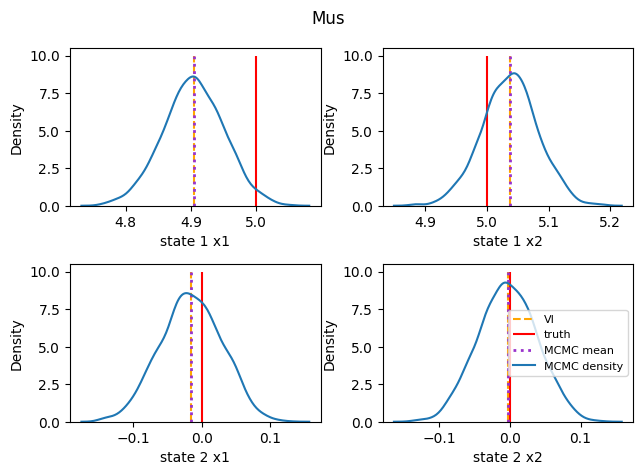

In [11]:
mus = [mu_21,mu_22,mu_11,mu_12]
phis = list(np.diag(phi_1))+list(np.diag(phi_2))
true_mus = [jump,jump,0,0]
# variance was set to 1 (identity)
for i, column in enumerate(fr.columns, 1):
    plt.subplot(2,2,i)
    plt.vlines(mus[i-1],0,10,color = 'orange',label='VI',linestyles='dashed')
    plt.vlines(true_mus[i-1],0,10,color = 'red',label='truth')
    plt.vlines(np.mean(fr[column]),0,10,color = 'darkorchid',linestyles='dotted',linewidth = 2, label='MCMC mean')
    sns.kdeplot(fr[column],common_norm=False,label='MCMC density')
plt.suptitle('Mus')
plt.legend(fontsize = 8)
plt.tight_layout()
    

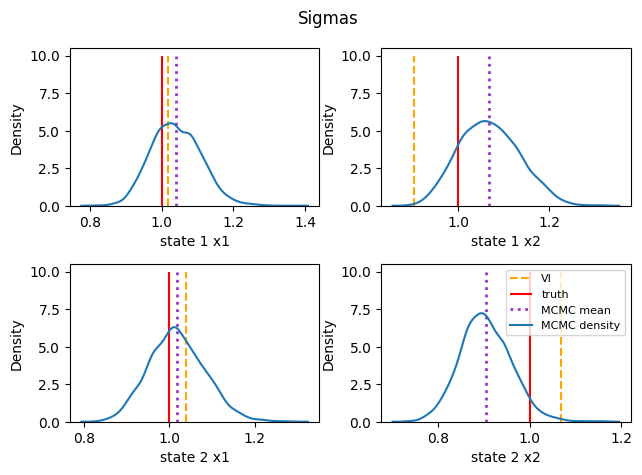

In [12]:
for i, column in enumerate(fr.columns, 1):
    plt.subplot(2,2,i)
    plt.vlines(phis[i-1],0,10,color = 'orange',label='VI',linestyles='dashed')
    plt.vlines(1,0,10,color = 'red',label='truth')
    plt.vlines(np.mean(sig[column]),0,10,color = 'darkorchid',linestyles='dotted',linewidth = 2, label='MCMC mean')
    sns.kdeplot(sig[column],common_norm=False,label='MCMC density')
plt.suptitle('Sigmas')
plt.legend(fontsize = 8)
plt.tight_layout()

## Matrix Expansion 

In [13]:
from matrix_expansion import *
test_matrix_expansion()

This is an example of how conversion HSMM to HMM transition matrix is done with expand_matrix()
The HSMM matrix is :
[[0.  0.8 0.2]
 [0.3 0.  0.7]
 [0.5 0.5 0. ]]
a_js are: [2 2 2]
lambda_js are: [1 2 3]
the 1- h vector is : [0.41802329 0.3038944 ]
the 1- h vector is : [0.68696471 0.54432116]
the 1- h vector is : [0.84281291 0.72024558]
sum of row entries :[1. 1. 1. 1. 1. 1.]
[[0.         0.41802329 0.46558137 0.         0.11639534 0.        ]
 [0.         0.3038944  0.55688448 0.         0.13922112 0.        ]
 [0.09391059 0.         0.         0.68696471 0.2191247  0.        ]
 [0.13670365 0.         0.         0.54432116 0.31897519 0.        ]
 [0.07859354 0.         0.07859354 0.         0.         0.84281291]
 [0.13987721 0.         0.13987721 0.         0.         0.72024558]]
